<a href="https://colab.research.google.com/github/zfathisalout/zfathisalout/blob/main/basic_svd_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic SVD Embeddings

In this exercise, you will create your own word embeddings using Singular Value Decomposition (SVD), a dimensionality reduction technique from linear algebra. This experience will provide you with a deeper understanding of how embeddings can be generated purely from a corpus of text.

**Important note:** Modern LLMs like GPT-2 automatically learn their embeddings during training, and do NOT use this technique. However, the process here is simpler and can help develop an intuition for how word embeddings can arise purely from useage statistics.

# Exercise Overview

In this you'll use a simplified approach to create word embeddings:

1. Build a corpus of text
2. Create a co-occurrence matrix from the corpus
3. Apply SVD to the matrix to generate embeddings
3. Visualize the results using PCA


# Step 0: Getting started

Run the cell below to import the libraries we'll use in this exercise.

In [ ]:
# Import the libraries we'll need for this exercise

import requests
from bs4 import BeautifulSoup
import re
from collections import defaultdict, Counter
import numpy as np
from scipy.sparse.linalg import svds
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt


# Step 1: Build a corpus of text

In this step we will build a corpus of text from four wikipedia articles.

Run the cells below. The next cell will prompt you for the URLs of four wikipedia articles and the subsequent cell will parse it into a corpus.

In the example below, I used the following URLs but feel free to use your own:

 - https://en.wikipedia.org/wiki/American_Revolutionary_War
 - https://en.wikipedia.org/wiki/Marie_Curie
 - https://en.wikipedia.org/wiki/Stonehenge
 - https://en.wikipedia.org/wiki/Olympic_Games


In [ ]:
# Prompt the user for four Wikipedia URLs
url1 = input("Enter the URL of Wikipedia article 1: ")
url2 = input("Enter the URL of Wikipedia article 2: ")
url3 = input("Enter the URL of Wikipedia article 3: ")
url4 = input("Enter the URL of Wikipedia article 4: ")

Enter the URL of Wikipedia article 1: https://en.wikipedia.org/wiki/American_Revolutionary_War
Enter the URL of Wikipedia article 2: https://en.wikipedia.org/wiki/Marie_Curie
Enter the URL of Wikipedia article 3: https://en.wikipedia.org/wiki/Stonehenge
Enter the URL of Wikipedia article 4: https://en.wikipedia.org/wiki/Olympic_Games


In [ ]:
# This cell uses the requests library to fetch the wikipedia pages
# and the BeautifulSoup library to parse their HTML into a plain text
# corpus.

# Extracts plain text from a wikipedia URL
def extract_wikipedia_text(url):
    # Request the Wikipedia page
    response = requests.get(url)
    if response.status_code != 200:
        return f"Failed to retrieve the page. Status code: {response.status_code}"

    # Parse the HTML page using BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the main content div
    content = soup.find(id="mw-content-text")

    if not content:
        return "Could not find the main content of the page."

    # Extract all paragraphs from the main content
    paragraphs = content.find_all('p')

    # Combine the text from all paragraphs
    article_text = '\n\n'.join([p.get_text() for p in paragraphs])

    return article_text


# Fetch and combine the wikipedia text into a corpus.
corpus = ""
corpus += extract_wikipedia_text(url1)
corpus += extract_wikipedia_text(url2)
corpus += extract_wikipedia_text(url3)
corpus += extract_wikipedia_text(url4)

# Step 2: Co-occurrence matrix

In this step we'll build a co-occurrence matrix from the corpus.

A co-occurrence matrix is a table that shows how often words appear together within a certain distance (called a "window") in the corpus. Each row and column represents a word, and the cells contain the count of how many times those words co-occur within the defined window.

In [ ]:
# Pick a window size (I used 8 in my example but you can experiment with other values)
window_size = 8

In [ ]:
# List of very common english words we'll exclude from our analysis.
STOP_WORDS = set(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"])

#
# Build a co-occurrence matrix
# We also will keep track of individual word freqnecy for later use
#

# Turn the corpus into a list of words
words = [word for word in re.findall(r'\b\w+\b', corpus.lower()) if word not in STOP_WORDS]
word_freq = Counter(words)

# Create a co_occurrence dictionary
co_occurrence = defaultdict(lambda: defaultdict(int))

# For every word in the corpus count the other words that occur within the window
for i, word in enumerate(words):
    for j in range(max(0, i - window_size), min(len(words), i + window_size + 1)):
        if i != j:
            co_occurrence[word][words[j]] += 1

# The structure above uses a dictionary to keep track of co-occurrence.
# Convert it to a numpy matrix which is what we'll need for calculating the SVD.
co_occurrence_keys = list(co_occurrence.keys())
word_to_id = {word: i for i, word in enumerate(co_occurrence_keys)}

matrix = np.zeros((len(co_occurrence_keys), len(co_occurrence_keys)))
for word1, coocs in co_occurrence.items():
    for word2, count in coocs.items():
        matrix[word_to_id[word1]][word_to_id[word2]] = count

# We don't use this value in the code but is referenced in the next
# text section.
number_of_unique_words = len(co_occurrence_keys)



# Step 3: Use SVD to create embeddings

In this step we'll used SVD to create word embeddings.

Our co-occurrence matrix has a row and column for every word so it is `number_of_unique_words` tall and wide.

SVD is a dimensionality reduction technique that will reduce the number of columns while preseving much of the information in the original matrix.

We'll apply SVD to get a new matrix that is `number_of_unique_words` tall but only `embedding_dim` wide. Each row of this matrix represents the embedding for a single word.

In [ ]:
# Set the number of dimensions in your word embedding. I choose 200 but feel free to experiment.
embedding_dim = 200

In [ ]:
# Call TruncatedSVD to generate our embeddings matrix.
# We set the random seed to a fixed value to ensure consistent results.
svd = TruncatedSVD(n_components=200, random_state=42)
embeddings = svd.fit_transform(matrix)
embeddings = normalize(embeddings) # Normalize to reduce bias for more frequent words

# Step 4: Visualize the results using PCA

In this step we'll visualize our embeddings using PCA.

Some questions to consider:

- Are similar words clustered together?
- Are words that tend to occur together near each other?
- Which words are better clustered than others?
- How might the results relate to your choice of articles in the corpus?

Remember that we're viewing a high-dimensional space in just two dimensions. It's possible some relationships might be clearer in higher dimensions.

In [ ]:
# Set how many of the most frequent words we'll plot.
# (We limit the number of words so the plot is easier to read.)
top_n = 200

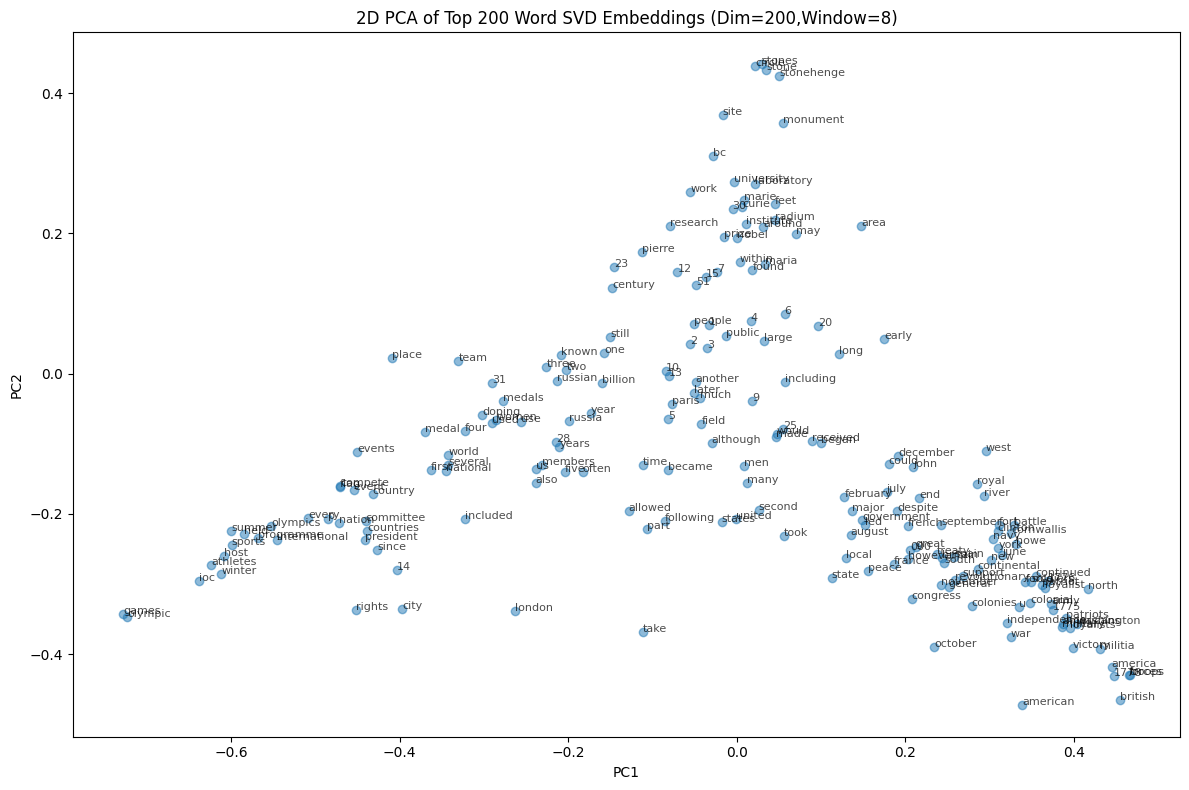

In [ ]:
# Perform PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot top N words
top_words = sorted(word_freq, key=word_freq.get, reverse=True)[:top_n]
top_indices = [word_to_id[word] for word in top_words]

plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[top_indices, 0], embeddings_2d[top_indices, 1], alpha=0.5)

for idx, word in zip(top_indices, top_words):
    x, y = embeddings_2d[idx]
    plt.annotate(word, (x, y), fontsize=8, alpha=0.7)

plt.title(f"2D PCA of Top {top_n} Word SVD Embeddings (Dim={embedding_dim},Window={window_size})")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()
